In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries

In [2]:
fs = glob.glob('data/O1/test/H-H1_LOSC_4_V1-1126256640-4096.gwf')

f = fs[-1]
kdq, kinj, kdata = get_channel_names(f)

# if looking at freq domain, need longer time segment to properly calculate fft
# 32s window around GW150914
tmin = 1126259446
tmax = tmin + 32

#series = TimeSeries.read(f, kdata)
data = TimeSeries.read(f, kdata, start=tmin, end=tmax)
#data = TimeSeries.fetch_open_data('H1', tmin, tmax) # download data in-place

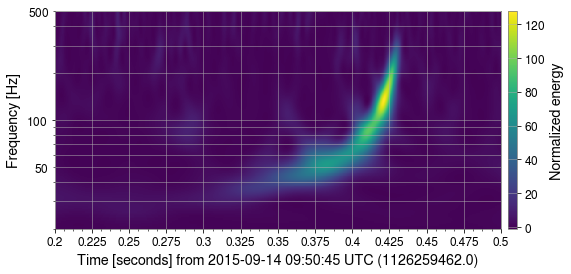

In [3]:
# Save computation/memory by only calculating **output** spectrogram on time segment of interest
# WARNING: Need to use sufficiently large time window around **input** waveform 
# in order to get good freq resolution in Fourier decomposition: about sg +/- 16 s
qspecgram = data.q_transform(outseg=(1126259462.2, 1126259462.5))
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

In [4]:
flow = 20
#high = data.highpass(15)
high = data.bandpass(flow, 600) # fhigh must be > max simulated freq of GW ~ 560 Hz
#psd = high.whiten(4,2).psd(4, 2) # whitening destroys SNR peak because matched filtering normalizes by PSD!
psd = high.psd(4, 2)
zoom = high.crop(1126259460, 1126259464)

In [5]:
psd.xspan

Segment(0.0, 2048.25)

In [6]:
from pycbc.waveform import get_fd_waveform
hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                        f_lower=flow, f_final=2048, delta_f=psd.df.value) #20

In [7]:
from pycbc.filter import matched_filter
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=flow) #15
snrts = TimeSeries.from_pycbc(snr).abs()

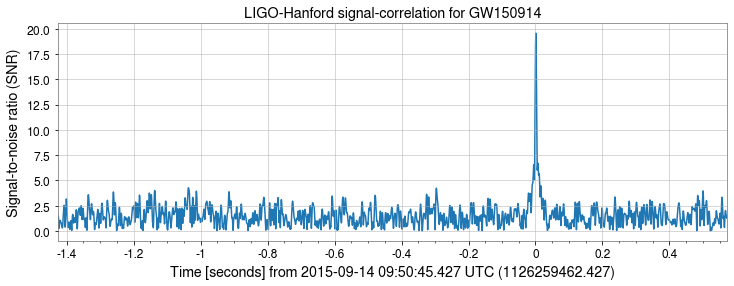

In [8]:
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(1126259461, 1126259463)
ax.set_epoch(1126259462.427)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')
plot.show()

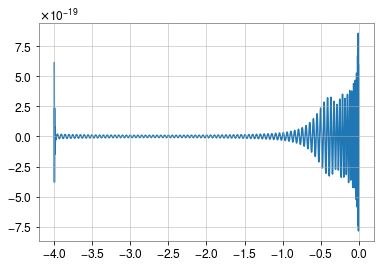

In [9]:
plot = hp.to_timeseries().plot()
#ax = plot.gca()
#ax.set_xlim(1126259461, 1126259463)
#ax.set_epoch(1126259462.427)
#ax.set_ylabel('Signal-to-noise ratio (SNR)')
#ax.set_title('LIGO-Hanford signal-correlation for GW150914')
#plot.show()